In [1]:
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Concatenate, GlobalMaxPooling2D, Dropout, Dense, Lambda, Reshape, Activation, Multiply, Add
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from transformers import TFViTForImageClassification
from keras.models import Sequential, Model
from keras import backend as K
from tensorflow import keras
import tensorflow as tf
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory

2025-04-09 16:35:20.239602: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


100%|██████████| 186/186 [00:01<00:00, 115.96it/s]


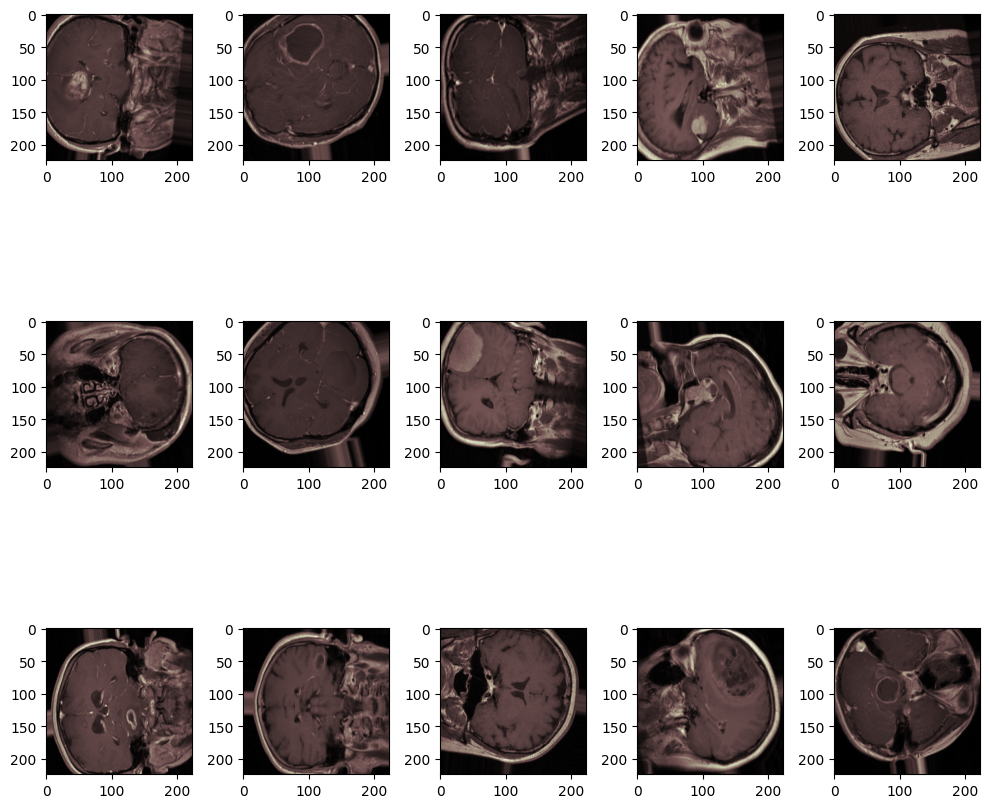

(614, 224, 224, 3)
(10534, 224, 224, 3)
(614, 3)
(10534, 3)


In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 224
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [3]:
model = TFViTForImageClassification.from_pretrained('/root/autodl-tmp/vit_model', num_labels=1000, use_safetensors=False)

model.classifier = tf.keras.Sequential([
    Dropout(0.5),
    Dense(3, activation='softmax')
])

def preprocess(x):
    x = (x - 0.5) / 0.5  
    x = tf.transpose(x, [0, 3, 1, 2]) 
    return x

inputs = Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(preprocess)(inputs)
outputs = model(x)
model = Model(inputs=inputs, outputs=outputs)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


2025-04-09 16:37:16.505311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-09 16:37:16.678908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22321 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:a9:00.0, compute capability: 8.9
All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at /root/autodl-tmp/vit_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassi

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 3, 224, 224)       0         
                                                                 
 tf_vi_t_for_image_classific  TFSequenceClassifierOutp  85800963 
 ation (TFViTForImageClassif  ut(loss=None, logits=(No           
 ication)                    ne, 3),                             
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
Total params: 85,800,963
Trainable params: 85,800,963
Non-trainable params: 0
_________________________________________________________________


In [4]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-test.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

Epoch 1/5


2025-04-09 16:38:08.392381: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2025-04-09 16:38:09.688683: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.2660 - accuracy: 0.9115
Epoch 1: val_accuracy improved from -inf to 0.98197, saving model to model-test.h5
Epoch 1: 68.62 seconds
264/264 [==============================] - 69s 202ms/step - loss: 0.2660 - accuracy: 0.9115 - val_loss: 0.0585 - val_accuracy: 0.9820 - lr: 1.0000e-04
Epoch 2/5
264/264 [==============================] - ETA: 0s - loss: 0.0553 - accuracy: 0.9825
Epoch 2: val_accuracy improved from 0.98197 to 0.98767, saving model to model-test.h5
Epoch 2: 53.01 seconds
264/264 [==============================] - 53s 201ms/step - loss: 0.0553 - accuracy: 0.9825 - val_loss: 0.0362 - val_accuracy: 0.9877 - lr: 1.0000e-04
Epoch 3/5
264/264 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9893
Epoch 3: val_accuracy did not improve from 0.98767
Epoch 3: 55.64 seconds
264/264 [==============================] - 56s 211ms/step - loss: 0.0389 - accuracy: 0.9893 - val_loss: 0.0711 - val_accuracy: 0.9829 

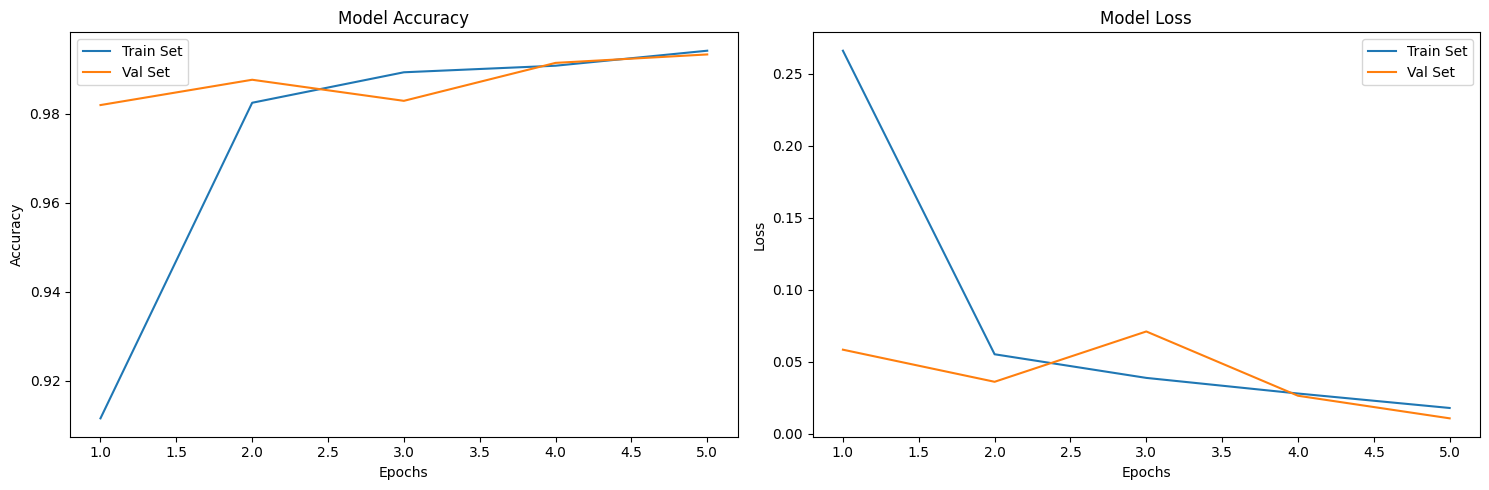

20/20 [==============================] - 1s 66ms/step - loss: 0.1405 - accuracy: 0.9691
Test Accuracy:  96.91
              precision    recall  f1-score   support

      glioma     0.9593    0.9895    0.9742       286
  meningioma     0.9574    0.9507    0.9541       142
   pituitary     0.9944    0.9516    0.9725       186

    accuracy                         0.9691       614
   macro avg     0.9704    0.9639    0.9669       614
weighted avg     0.9695    0.9691    0.9690       614



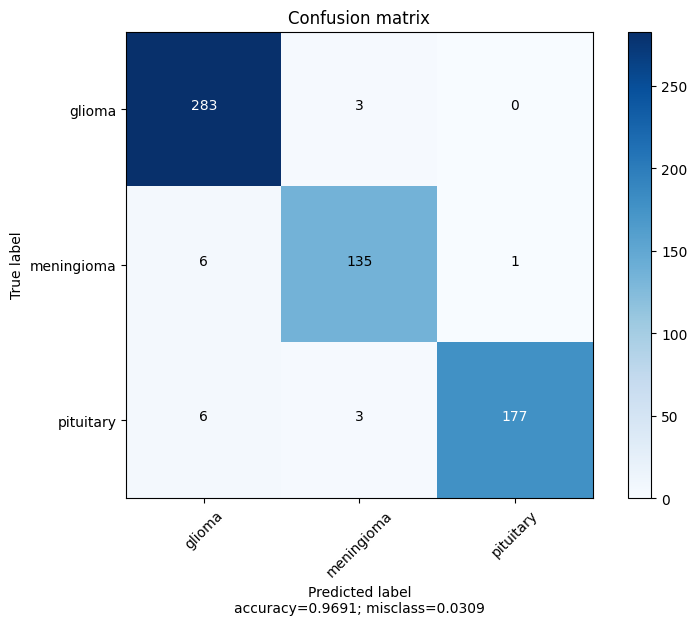

In [7]:
draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred.logits,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at /root/autodl-tmp/vit_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


Epoch 1/5
264/264 [==============================] - ETA: 0s - loss: 0.2704 - accuracy: 0.9053
Epoch 1: val_accuracy improved from -inf to 0.95825, saving model to model-test.h5
Epoch 1: 74.35 seconds
264/264 [==============================] - 74s 228ms/step - loss: 0.2704 - accuracy: 0.9053 - val_loss: 0.1087 - val_accuracy: 0.9583 - lr: 1.0000e-04
Epoch 2/5
264/264 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9840
Epoch 2: val_accuracy improved from 0.95825 to 0.98197, saving model to model-test.h5
Epoch 2: 54.84 seconds
264/264 [==============================] - 55s 208ms/step - loss: 0.0468 - accuracy: 0.9840 - val_loss: 0.0486 - val_accuracy: 0.9820 - lr: 1.0000e-04
Epoch 3/5
264/264 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9898
Epoch 3: val_accuracy improved from 0.98197 to 0.98577, saving model to model-test.h5
Epoch 3: 54.18 seconds
264/264 [==============================] - 54s 205ms/step - loss: 0.0281 - accuracy: 0.98

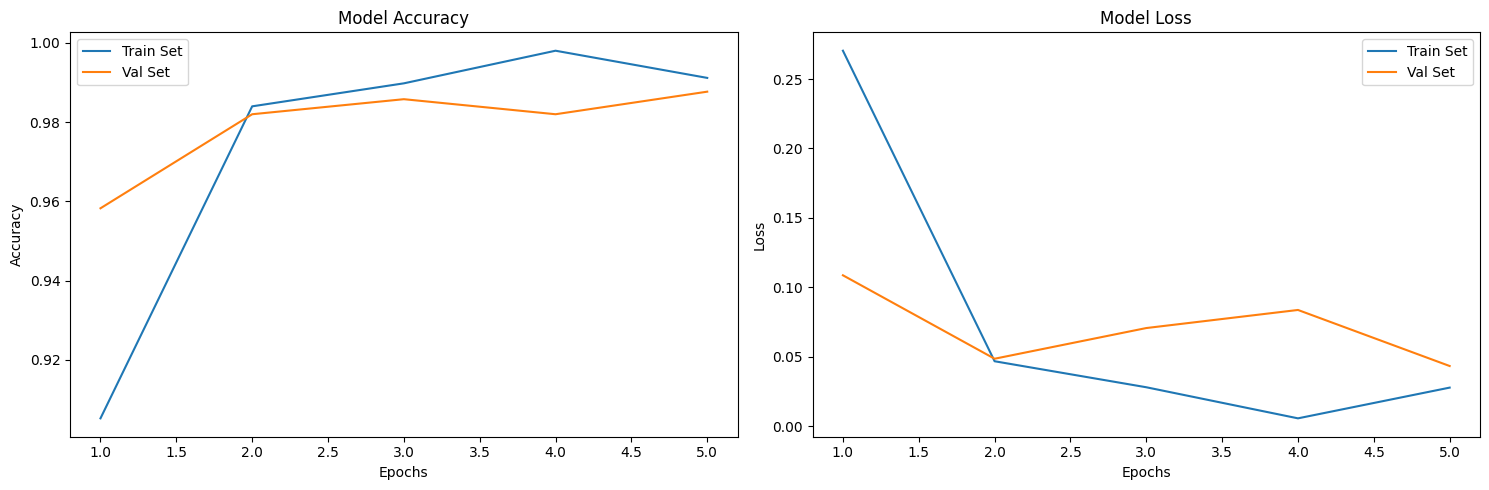

20/20 [==============================] - 2s 75ms/step - loss: 0.1412 - accuracy: 0.9625
Test Accuracy:  96.25
              precision    recall  f1-score   support

      glioma     0.9892    0.9580    0.9734       286
  meningioma     0.9252    0.9577    0.9412       142
   pituitary     0.9526    0.9731    0.9628       186

    accuracy                         0.9625       614
   macro avg     0.9557    0.9630    0.9591       614
weighted avg     0.9633    0.9625    0.9627       614



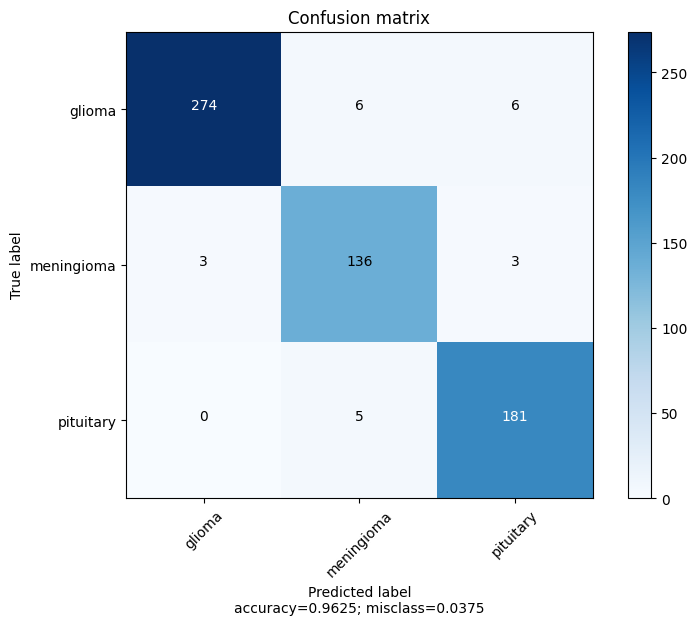

In [8]:
model = TFViTForImageClassification.from_pretrained('/root/autodl-tmp/vit_model', num_labels=1000, use_safetensors=False)

model.classifier = tf.keras.Sequential([
    Dropout(0.5),
    Dense(3, activation='softmax')
])

def preprocess(x):
    x = (x - 0.5) / 0.5  
    x = tf.transpose(x, [0, 3, 1, 2]) 
    return x

inputs = Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(preprocess)(inputs)
outputs = model(x)
model = Model(inputs=inputs, outputs=outputs)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-test.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred.logits,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at /root/autodl-tmp/vit_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


Epoch 1/5
264/264 [==============================] - ETA: 0s - loss: 0.2484 - accuracy: 0.9110
Epoch 1: val_accuracy improved from -inf to 0.96300, saving model to model-test.h5
Epoch 1: 72.45 seconds
264/264 [==============================] - 72s 222ms/step - loss: 0.2484 - accuracy: 0.9110 - val_loss: 0.1153 - val_accuracy: 0.9630 - lr: 1.0000e-04
Epoch 2/5
264/264 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9829
Epoch 2: val_accuracy improved from 0.96300 to 0.98008, saving model to model-test.h5
Epoch 2: 55.33 seconds
264/264 [==============================] - 55s 210ms/step - loss: 0.0511 - accuracy: 0.9829 - val_loss: 0.0548 - val_accuracy: 0.9801 - lr: 1.0000e-04
Epoch 3/5
264/264 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9930
Epoch 3: val_accuracy did not improve from 0.98008
Epoch 3: 52.74 seconds
264/264 [==============================] - 53s 200ms/step - loss: 0.0210 - accuracy: 0.9930 - val_loss: 0.1954 - val_accurac

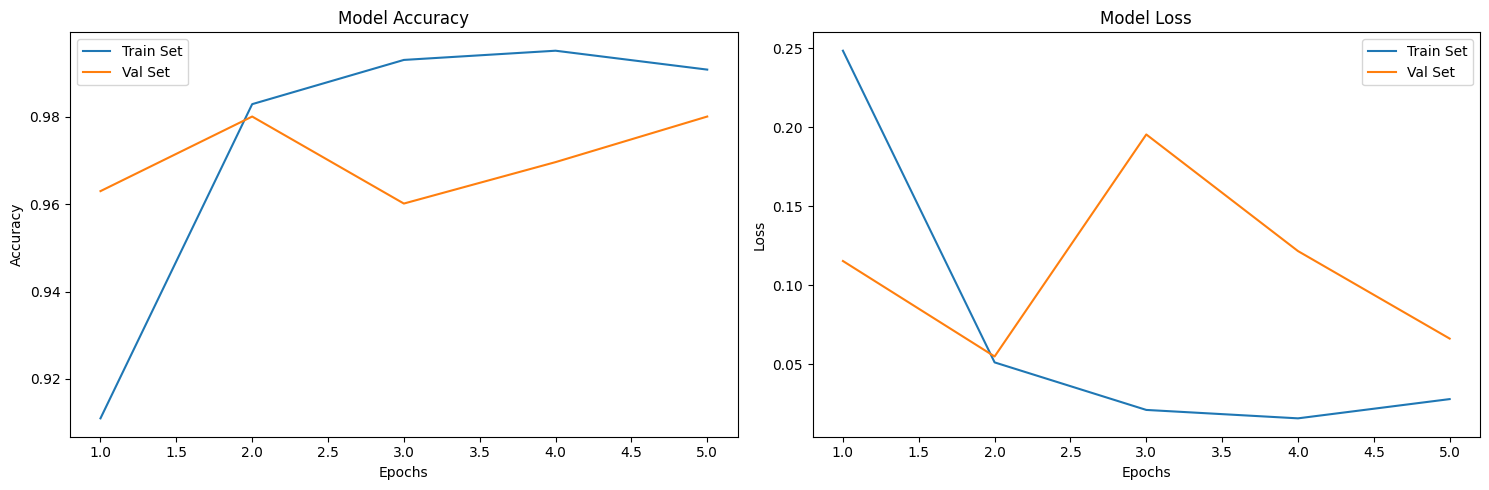

20/20 [==============================] - 1s 66ms/step - loss: 0.0932 - accuracy: 0.9772
Test Accuracy:  97.72
              precision    recall  f1-score   support

      glioma     0.9928    0.9650    0.9787       286
  meningioma     0.9586    0.9789    0.9686       142
   pituitary     0.9686    0.9946    0.9814       186

    accuracy                         0.9772       614
   macro avg     0.9733    0.9795    0.9763       614
weighted avg     0.9776    0.9772    0.9772       614



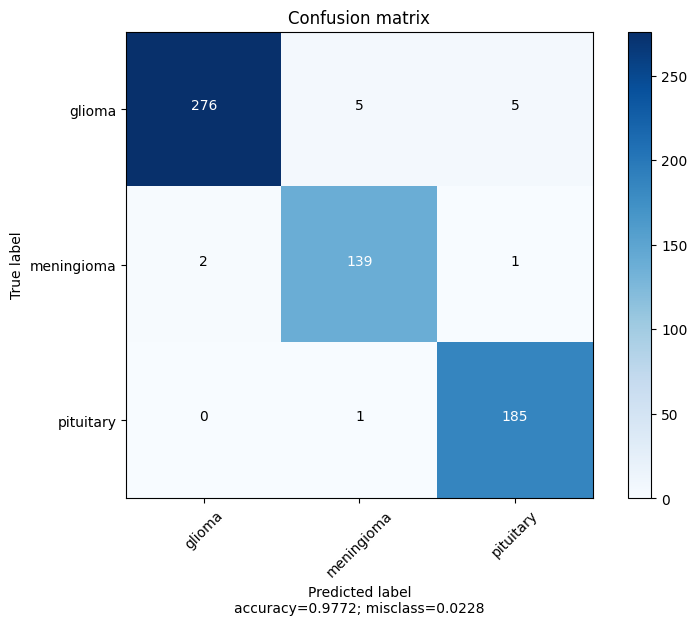

In [9]:
model = TFViTForImageClassification.from_pretrained('/root/autodl-tmp/vit_model', num_labels=1000, use_safetensors=False)

model.classifier = tf.keras.Sequential([
    Dropout(0.5),
    Dense(3, activation='softmax')
])

def preprocess(x):
    x = (x - 0.5) / 0.5  
    x = tf.transpose(x, [0, 3, 1, 2]) 
    return x

inputs = Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(preprocess)(inputs)
outputs = model(x)
model = Model(inputs=inputs, outputs=outputs)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-test.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred.logits,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at /root/autodl-tmp/vit_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


Epoch 1/5
264/264 [==============================] - ETA: 0s - loss: 0.2674 - accuracy: 0.9024
Epoch 1: val_accuracy improved from -inf to 0.97249, saving model to model-test.h5
Epoch 1: 73.54 seconds
264/264 [==============================] - 74s 236ms/step - loss: 0.2674 - accuracy: 0.9024 - val_loss: 0.0675 - val_accuracy: 0.9725 - lr: 1.0000e-04
Epoch 2/5
264/264 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.9852
Epoch 2: val_accuracy did not improve from 0.97249
Epoch 2: 54.95 seconds
264/264 [==============================] - 55s 208ms/step - loss: 0.0484 - accuracy: 0.9852 - val_loss: 0.1039 - val_accuracy: 0.9706 - lr: 1.0000e-04
Epoch 3/5
264/264 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9925
Epoch 3: val_accuracy did not improve from 0.97249
Epoch 3: 58.00 seconds
264/264 [==============================] - 58s 220ms/step - loss: 0.0238 - accuracy: 0.9925 - val_loss: 0.1485 - val_accuracy: 0.9554 - lr: 1.0000e-04
Epoch 4/

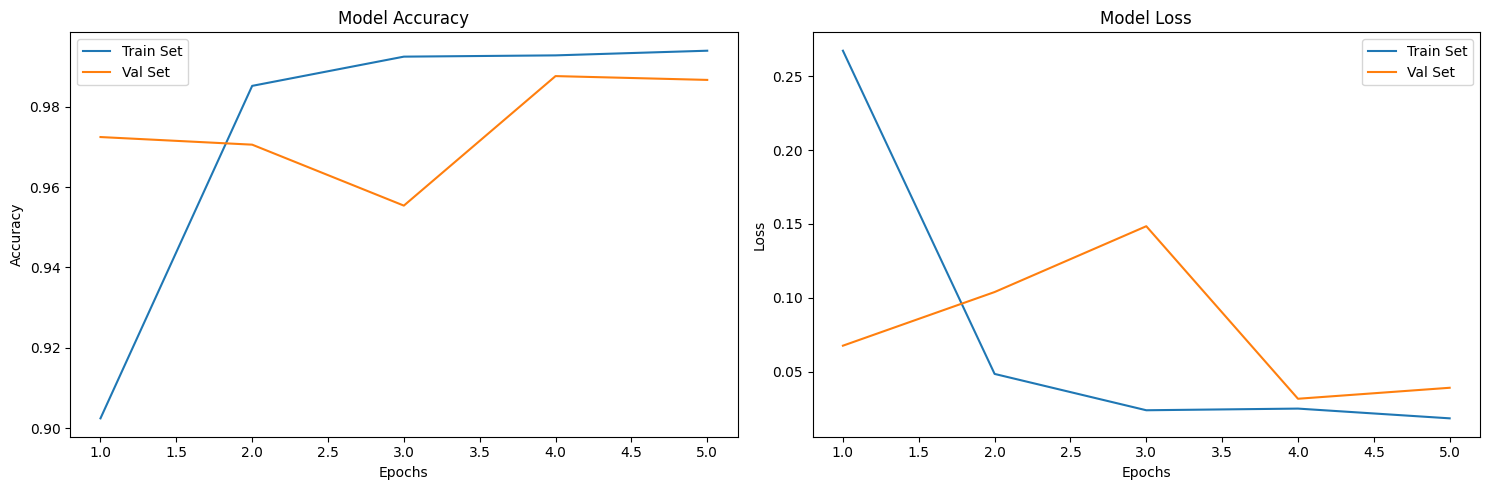

20/20 [==============================] - 1s 65ms/step - loss: 0.1137 - accuracy: 0.9674
Test Accuracy:  96.74
              precision    recall  f1-score   support

      glioma     0.9656    0.9825    0.9740       286
  meningioma     0.9306    0.9437    0.9371       142
   pituitary     1.0000    0.9624    0.9808       186

    accuracy                         0.9674       614
   macro avg     0.9654    0.9628    0.9640       614
weighted avg     0.9679    0.9674    0.9675       614



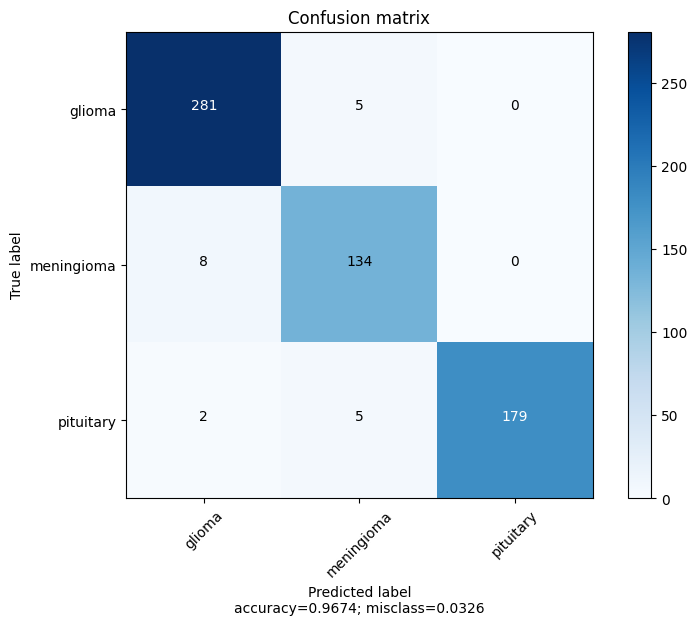

In [10]:
model = TFViTForImageClassification.from_pretrained('/root/autodl-tmp/vit_model', num_labels=1000, use_safetensors=False)

model.classifier = tf.keras.Sequential([
    Dropout(0.5),
    Dense(3, activation='softmax')
])

def preprocess(x):
    x = (x - 0.5) / 0.5  
    x = tf.transpose(x, [0, 3, 1, 2]) 
    return x

inputs = Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(preprocess)(inputs)
outputs = model(x)
model = Model(inputs=inputs, outputs=outputs)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-test.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred.logits,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at /root/autodl-tmp/vit_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


Epoch 1/5
264/264 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.9057
Epoch 1: val_accuracy improved from -inf to 0.97533, saving model to model-test.h5
Epoch 1: 69.34 seconds
264/264 [==============================] - 69s 213ms/step - loss: 0.2756 - accuracy: 0.9057 - val_loss: 0.0758 - val_accuracy: 0.9753 - lr: 1.0000e-04
Epoch 2/5
264/264 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.9825
Epoch 2: val_accuracy improved from 0.97533 to 0.98767, saving model to model-test.h5
Epoch 2: 54.56 seconds
264/264 [==============================] - 55s 207ms/step - loss: 0.0510 - accuracy: 0.9825 - val_loss: 0.0319 - val_accuracy: 0.9877 - lr: 1.0000e-04
Epoch 3/5
264/264 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9914
Epoch 3: val_accuracy did not improve from 0.98767
Epoch 3: 52.39 seconds
264/264 [==============================] - 52s 198ms/step - loss: 0.0287 - accuracy: 0.9914 - val_loss: 0.0347 - val_accurac

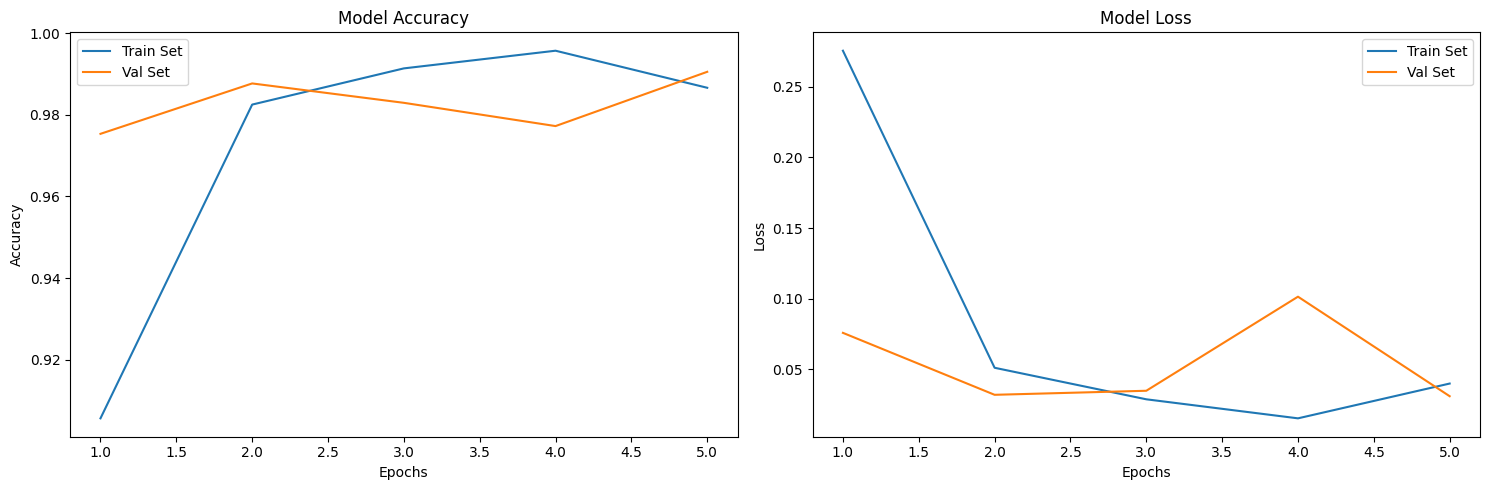

20/20 [==============================] - 1s 66ms/step - loss: 0.1348 - accuracy: 0.9723
Test Accuracy:  97.23
              precision    recall  f1-score   support

      glioma     0.9690    0.9825    0.9757       286
  meningioma     0.9441    0.9507    0.9474       142
   pituitary     1.0000    0.9731    0.9864       186

    accuracy                         0.9723       614
   macro avg     0.9710    0.9688    0.9698       614
weighted avg     0.9726    0.9723    0.9724       614



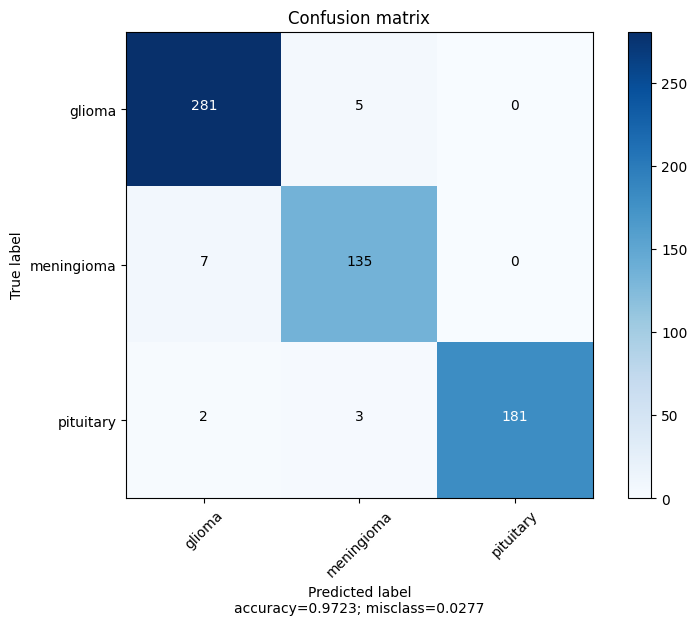

In [11]:
model = TFViTForImageClassification.from_pretrained('/root/autodl-tmp/vit_model', num_labels=1000, use_safetensors=False)

model.classifier = tf.keras.Sequential([
    Dropout(0.5),
    Dense(3, activation='softmax')
])

def preprocess(x):
    x = (x - 0.5) / 0.5  
    x = tf.transpose(x, [0, 3, 1, 2]) 
    return x

inputs = Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(preprocess)(inputs)
outputs = model(x)
model = Model(inputs=inputs, outputs=outputs)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-test.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred.logits,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)